In [19]:
%%capture
%pip install unsupervised_multimodal_trajectory_modeling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/burkh4rt/Unsupervised-Trajectory-Clustering-Starter/blob/ipynb/data_synthetic.ipynb)
## Utilities for loading and plotting a dataset

In [13]:
from __future__ import annotations

import functools
import itertools
import pathlib
import string

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skl_mets

from unsupervised_multimodal_trajectory_modeling.util import (
    util_state_space as ss_util,
)
from unsupervised_multimodal_trajectory_modeling.linear_gaussian import (
    marginalizable_state_space_model as mssm,
    marginalizable_mixture_model as mixmodel,
)

name = "synthetic"
pwd = pathlib.Path().absolute()

In [14]:
def get_default_model() -> dict:
    n_clusters = 3
    d_hidden = 2
    d_observed = 3
    cluster_propensities = np.array([0.4, 0.3, 0.3])

    # form model parameters
    A = np.empty(shape=(n_clusters, d_hidden, d_hidden))
    Γ = np.empty(shape=(n_clusters, d_hidden, d_hidden))
    H = np.empty(shape=(n_clusters, d_hidden, d_observed))
    Λ = np.empty(shape=(n_clusters, d_observed, d_observed))
    μ = np.empty(shape=(n_clusters, d_hidden))

    # healthy cluster
    μ[0] = np.array([1.0, 0.95])
    A[0] = np.eye(d_hidden)
    Γ[0] = 0.001 + 0.001 * np.eye(d_hidden)
    H[0] = np.array([[1, -1, 0], [1, 1, 1]])
    Λ[0] = 0.001 + 0.001 * np.eye(d_observed)

    # middle cluster
    μ[1] = np.array([1.0, 0.8])
    A[1] = np.diag([1.1, 0.9])
    Γ[1] = 0.002 + 0.001 * np.eye(d_hidden)
    H[1] = H[0].copy()
    Λ[1] = 0.002 + 0.001 * np.eye(d_observed)

    # diseased cluster
    μ[2] = np.array([1.2, 0.8])
    A[2] = np.array([[1.2, -0.1], [-0.1, 0.8]])
    Γ[2] = 0.005 + 0.01 * np.eye(d_hidden)
    H[2] = H[0].copy()
    Λ[2] = 0.01 + 0.01 * np.eye(d_observed)

    return {"μ": μ, "A": A, "Γ": Γ, "H": H, "Λ": Λ, "π": cluster_propensities}


def get_data_by_length(
    n_data: int,
    n_timesteps: int,
    *,
    rng=np.random.default_rng(42),
    mdl: dict[str, np.ndarray] = get_default_model(),
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """creates n_data trajectories of the specified length

    Parameters
    ----------
    n_data
        number of trajectories to create
    n_timesteps
        length of each trajectory
    rng
        (optionally) provide rng to control randomness
    mdl
        provide a model specification for data generation

    Returns
    -------
    tuple of hidden states, observed states, clusters

    """

    μ, A, Γ, H, Λ, π = (
        mdl["μ"],
        mdl["A"],
        mdl["Γ"],
        mdl["H"],
        mdl["Λ"],
        mdl["π"],
    )

    n_clusters, d_hidden, d_observed = H.shape
    assert A.shape == (n_clusters, d_hidden, d_hidden)
    assert Γ.shape == (n_clusters, d_hidden, d_hidden)
    assert Λ.shape == (n_clusters, d_observed, d_observed)
    assert μ.shape == (n_clusters, d_hidden)
    assert π.size == n_clusters

    # generate data according to model
    z = np.empty(shape=(n_timesteps, n_data, d_hidden))
    x = np.empty(shape=(n_timesteps, n_data, d_observed))
    c = np.empty(shape=(n_data,), dtype=int)

    for i in range(n_data):
        c[i] = rng.choice(np.arange(n_clusters), p=π.ravel())
        z[:, i, :], x[:, i, :] = map(
            np.squeeze,
            mssm.sample_trajectory(
                1,
                n_timesteps,
                μ[c[i]],
                Γ[c[i]],
                A[c[i]],
                Γ[c[i]],
                H[c[i]],
                Λ[c[i]],
            ),
        )

    return z, x, c


def get_data(
    n_data: int,
    *,
    rng=np.random.default_rng(42),
    mdl: dict = get_default_model(),
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """returns trajectories w/ lengths 2,3,4 of the standard data

    Parameters
    ----------
    n_data
        number of trajectories to return
    rng
        (optionally) provide rng to control randomness
    mdl
        specify model parameters as in `get_data_by_length`

    Returns
    -------
    tuple of hidden states, observed states, clusters, ids, times

    See Also
    --------
    get_data_by_length

    """

    n4, n3, n2 = rng.multinomial(n_data, [2 / 5, 2 / 5, 1 / 5])

    z4, x4, c4 = get_data_by_length(n_data=n4, n_timesteps=4, rng=rng, mdl=mdl)
    z3, x3, c3 = get_data_by_length(n_data=n3, n_timesteps=3, rng=rng, mdl=mdl)
    z2, x2, c2 = get_data_by_length(n_data=n2, n_timesteps=2, rng=rng, mdl=mdl)

    z = functools.reduce(ss_util.nancat, [z2, z3, z4])
    x = functools.reduce(ss_util.nancat, [x2, x3, x4])
    c = np.array([*c2, *c3, *c4])

    ids = np.tile(np.arange(n_data), (z.shape[0], 1))[:, :, np.newaxis]
    times = np.tile(np.arange(z.shape[0])[:, np.newaxis], (1, z.shape[1]))[
        :, :, np.newaxis
    ]

    return z, x, c, ids, times


def set_model_correspondence(mdl, true_labels: np.array) -> None:
    """takes a trained model and sets the cluster correspondence to minimise
     the discrepancy between A,B,C and 1,2,3 -- note that clusters are only
     determined up to relabelling; i.e. the labels themselves don't matter

    Parameters
    ----------
    mdl
        trained model
    true_labels
        n_data array of `true` assignments

    """
    true_labels = np.array(true_labels).astype(int).ravel()

    def discrepancy(it):
        """sums the off-diagonal elements for the confusion matrix
        corresponding to the permutation relabelling `it`

        Parameters
        ----------
        it
            permutation of the labels

        Returns
        -------
        discrepancy associated with using the permuted labels

        """
        m = skl_mets.confusion_matrix(
            true_labels, np.array(it)[mdl.cluster_assignment]
        )
        return np.sum(m) - np.trace(m)

    best_iter = min(
        itertools.permutations(range(mdl.n_clusters)),
        key=lambda it: np.sum(
            true_labels != np.array(it)[mdl.cluster_assignment].ravel()
        ),
    )
    mdl.correspondence = dict(
        zip(
            range(mdl.n_clusters),
            np.array(list(string.ascii_uppercase))[np.array(best_iter)],
        )
    )


def plot_2d_trajectories(
    model,
    *,
    title: str = "Latent trajectories by cluster",
    hidden_states: np.array = None,
    inferred_clusters: np.array = None,
    std_param: dict[str, np.array] = None,
    show: bool = False,
) -> None:
    """plots 2d trajectories and colors by inferred cluster membership

    Parameters
    ----------
    model
        mixture model instance
    title: str
        title for figure
    hidden_states
        (optional) states to plot
        defaults to model's training data
    inferred_clusters
        (optional) inferred cluster membership for colouring the trajectories
        defaults to inferred clusters for training data
    std_param
        (optional) plot initial state densities for clusters as a sanity check
    show
        show the resulting plot?

    Returns
    -------
    plots of trajectories colored by inferred cluster membership
    """
    if hidden_states is None:
        hidden_states = model.states
    if inferred_clusters is None:
        inferred_clusters = np.array(
            [model.correspondence[c] for c in model.cluster_assignment]
        )
    n_clusters = (
        len(set(inferred_clusters).intersection(set(string.ascii_letters)))
        if model is None
        else model.n_clusters
    )

    assert hidden_states.ndim == 3 and hidden_states.shape[-1] == 2
    assert hidden_states.shape[1] == len(inferred_clusters)

    # plot out hidden trajectories colored by cluster
    # for training data
    fig, ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    for i, c in enumerate(string.ascii_uppercase[:n_clusters]):
        if np.sum(inferred_clusters == c) == 0:
            continue
        xcinit = hidden_states[:-1, inferred_clusters == c, 0].ravel()
        ycinit = hidden_states[:-1, inferred_clusters == c, 1].ravel()
        xcdir = np.diff(
            hidden_states[:, inferred_clusters == c, 0], axis=0
        ).ravel()
        ycdir = np.diff(
            hidden_states[:, inferred_clusters == c, 1], axis=0
        ).ravel()
        assert len(xcinit) == len(ycinit) == len(xcdir) == len(ycdir)
        cids = functools.reduce(
            np.logical_and,
            map(np.isfinite, [xcinit, ycinit, xcdir, ycdir]),
        )
        plt.quiver(
            xcinit[cids],
            ycinit[cids],
            xcdir[cids],
            ycdir[cids],
            color=(
                "#0072CE",
                "#E87722",
                "#64A70B",
                "#93328E",
                "#A81538",
                "#4E5B31",
            )[i],
            linestyle="solid",
            units="xy",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.003,
            zorder=-1.0 * i,
        )
        plt.scatter(
            hidden_states[:, inferred_clusters == c, 0].ravel(),
            hidden_states[:, inferred_clusters == c, 1].ravel(),
            color=(
                "#0072CE",
                "#E87722",
                "#64A70B",
                "#93328E",
                "#A81538",
                "#4E5B31",
            )[i],
            marker=("o", "v", "^", "s", "+", "x")[i],
            label=f"cluster {c}",
            s=5,
            zorder=-1.0 * i,
        )
    handles, labels = ax.get_legend_handles_labels()
    unique_labels_dict = dict(zip(labels, handles))
    ax.legend(
        unique_labels_dict.values(),
        unique_labels_dict.keys(),
        fontsize="large",
    )
    plt.title(title)
    xlim, ylim = zip(
        np.nanmin(hidden_states, axis=(0, 1)),
        np.nanmax(hidden_states, axis=(0, 1)),
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if std_param is not None:
        model.superimpose_model_on_plot(ax, std_param=std_param)
    if show:
        fig.show()
    return fig

### Load and plot some data

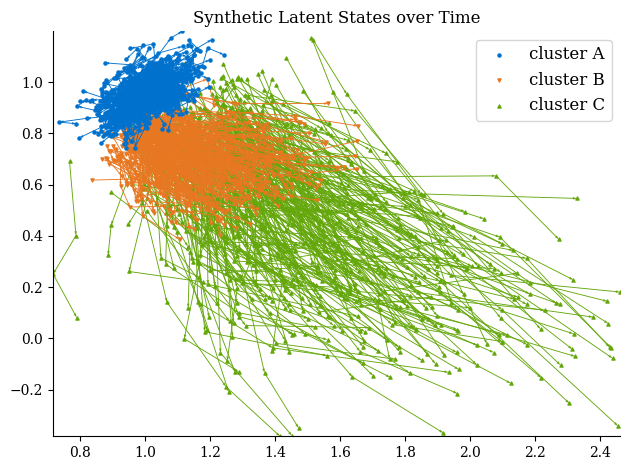

In [15]:
z, x, c, _, _ = get_data(1000, rng=np.random.default_rng(42))
fig = plot_2d_trajectories(
    None,
    title="Synthetic Latent States over Time",
    hidden_states=z,
    inferred_clusters=np.array(list(string.ascii_uppercase))[c],
    show=False,
)